# 4 - Treinamento de modelos

Nessa fase, treinaremos os modelos classificadores candidatos. 

Nessa etapa o problema se torna semelhante aos modelos de ML tradicionais: testaremos diversos classificadores como *RandomForest*, *AdaBoost*, entre outros, e otimizaremos também os hiperparâmetros do modelo com técnicas como a *GridSearch* e a *RandomizedSearch*.

In [1]:
# caminho para instalação do pacote mltoolkit, com metricas e gráficos personalizados
# !pip install git+ssh://git@github.com/flimao/mltoolkit

In [2]:
import pandas as pd
import numpy as np
from matplotlib import rcParams, rcParamsDefault, pyplot as plt
import seaborn as sns
from mltoolkit import metrics, plots, NLP
import spacy
from tqdm import tqdm

rcParams.update(rcParamsDefault)
rcParams['figure.dpi'] = 120
rcParams['figure.figsize'] = (10, 8)

tqdm.pandas()

In [3]:
# !python -m spacy download pt_core_news_lg
# !python -m spacy download pt_core_news_md
# !python -m spacy download pt_core_news_sm
nlp = spacy.load("pt_core_news_lg")

## Importação dos dados

Primeiramente, importamos os dados e aplicamos as transformações utilizadas na fase anterior:

In [4]:
# não tocaremos no conjunto de submissão

tweets_raw = pd.read_csv(
    r'../data/Train3Classes.csv',
)

In [5]:
# trocar tipos para acelerar o processamento (menos espaço em memória)
# e ativar possíveis otimizações internas ao pandas para certos tipos
def mudar_tipos(df):
    df = df.copy()

    df['id'] = df['id'].astype('string')
    df['tweet_date'] = pd.to_datetime(df['tweet_date'])
    df['sentiment'] = df['sentiment'].astype('category')

    return df

def remover_duplicatas(df):
    df = df.copy()

    df = df.drop_duplicates(subset = 'id')

    return df

# o índice é o id, visto que não há repetidos
# vantagem: o índice é removido automaticamente quando separamos em base de treino e teste.
def setar_index(df):
    df = df.copy()

    df = df.set_index('id')

    return df

tweets_full = (tweets_raw
    .pipe(mudar_tipos)
    .pipe(remover_duplicatas)
    .pipe(setar_index)
)

## Pré-processamento de texto

Vamos então implementar o pré-processamento do texto da fase anterior (Análise Exploratória de Texto).

Primeiramente vamos importar as *stopwords*:

In [6]:
with open(r'../data/stopwords_alopes.txt', encoding = 'utf8') as stopword_list:
    lst = stopword_list.read().splitlines()

stopwords_alopes = set([ stopword.strip() for stopword in lst ])

# em uma análise de sentimento, não queremos remover palavras com conotação negativa
remover_stopwords = {
    'não', 
}

stopwords_alopes -= remover_stopwords

In [7]:
preprocessing_full = lambda s: NLP.preprocessing(s, preproc_funs_args = [
    NLP.remove_links,
    NLP.remove_hashtags,
    NLP.remove_mentions,
    NLP.remove_numbers,
    NLP.remove_special_caract,
    NLP.lowercase,
    #remove_punkt,
    #(remove_stopwords, dict(stopword_list = stopword_list_alopes)),
    (NLP.tokenize_remove_stopwords_get_radicals_spacy, dict(
        nlp = nlp,
        stopword_list = stopwords_alopes,
    )),
])

Vamos então aplicar esse pré-processamento a uma amostra da base de *tweets* (para podermos iterar rapidamente caso necessário). 

Em um momento posterior, treinaremos a base completa.

In [8]:
amostra_eda = 5000
radicais = tweets_full.sample(amostra_eda)['tweet_text'].progress_apply(preprocessing_full)

tweets = tweets_full.copy()
tweets['radicais'] = radicais
tweets = tweets[tweets.radicais.notna()]

100%|██████████| 5000/5000 [00:24<00:00, 204.51it/s]


In [9]:
tweets.sample(10)

,tweet_text,tweet_date,sentiment,query_used,radicais
id,,,,,
1049278847697539072,@nocedanielle Me diz pelo menos que a mãe do P...,2018-10-08 12:42:26+00:00,0,:(,mae paulo nao votar fascista amar senhor
1049262635458473990,Meu estômago tá doendo :(,2018-10-08 11:38:01+00:00,0,:(,estomagar ta doer
1049172777822040065,tão linda o anjinho :( 💖 https://t.co/HP06XriVMT,2018-10-08 05:40:57+00:00,0,:(,tao lindo anjo
1047394155700387840,@RodrigoRebesch Feliz aniversário. Não fica fo...,2018-10-03 07:53:21+00:00,1,:),feliz aniversariar nao ficar focar mensagem mi...
1049164521233948672,@hobimysavior Fico muito triste em ver o meu p...,2018-10-08 05:08:09+00:00,0,:(,ficar triste
1046768209221816321,o cabelo dela :( https://t.co/it5ClnOlKW,2018-10-01 14:26:03+00:00,0,:(,cabelar
1042557710103977985,Haddad quer manter regime de atuação do Banco ...,2018-09-19 23:35:02+00:00,2,folha,haddad manter regime atuacao banco central
1050779816885149696,@kauannefelicio Sei não ein.... você e Ester T...,2018-10-12 16:06:45+00:00,1,:),nao ein voce ester tigre dificil lindo
1047554378779881472,Menina que tentou matar os pais com veneno no ...,2018-10-03 18:30:01+00:00,2,g1,menino tentar matar pai veneno cafe querer mor...


## Treinamento de modelos

Vamos agora testar vários modelos de aprendizado de máquina, comparando-os para escolher o melhor.

### Preparação

In [10]:
X = tweets['radicais'] + ' ' + tweets['query_used'] # conforme dito na fase de Análise Exploratória
y = tweets['sentiment']

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.3,
    stratify = y
)

### Definição do *pipeline*

Vamos montar um *pipeline* de processamento do `scikit-learn`. Dessa forma, podemos automatizar o processo de otimização de hiperparâmetros após a escolha do melhor modelo.

Um *pipeline* é composto de um ou mais *transformers* e um estimador ao final. Os *transformers* tem como função transformar os dados, de forma que eles possam ser usados como entrada para um estimador, que usará os dados para fazer estimativas.

No nosso caso, a nossa *pipeline* será composta de um *transformer* e um estimador, detalhados a seguir.

#### Definição dos *Transformers*

No nosso caso, os *transformers* terão como *input* os *tweets* já pré-processados (mas ainda em formato de texto), e terão como saída uma série de *features* numéricas.

Testaremos 4 *transformers* diferentes:

In [12]:
pipeline_transformers = {}

##### ***Bag of Words* (`CountVectorizer`)**

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer()

pipeline_transformers['bow'] = bow

##### ***Bag of Words* - TF-IDF**

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(use_idf=True)

pipeline_transformers['tfidf'] = tfidf

##### ***Word2Vec***

In [15]:
from mltoolkit.NLP import W2VTransformer

word2vec = W2VTransformer(
    vector_size = 50,
    min_count = 2,
    workers = 2
)

pipeline_transformers['word2vec'] = word2vec

##### ***Doc2Vec***

In [16]:
from mltoolkit.NLP import D2VTransformer

doc2vec = D2VTransformer(
    vector_size = 50,
    min_count = 2,
    workers = 2
)

pipeline_transformers['doc2vec'] = doc2vec

#### Definição dos estimadores

Os estimadores são os diferentes modelos de aprendizado de máquina, que utilizaremos para predizer o tom (sentimento) de um *tweet* qualquer.

In [17]:
from copy import deepcopy

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# para reproducibilidade
random_seed = 42

pipeline_estimadores = {
    'logistic': LogisticRegression(random_state = random_seed),
    'random_forest': RandomForestClassifier(random_state = random_seed),
    'adaboost': AdaBoostClassifier(random_state = random_seed),
    'xgboost': XGBClassifier(random_state = random_seed, eval_metric = 'logloss', use_label_encoder = False),
}

#### Preparação do *pipeline*

Vamos agora cruzar cada *transformer* com cada estimador, e rodar os *pipelines* resultantes.

In [19]:
from sklearn.pipeline import Pipeline

pipelines = {}

# construindo as pipelines
for nome_transformer, transformer in pipeline_transformers.items():
    for nome_estimador, estimador in pipeline_estimadores.items():
        pipelines[f'{nome_estimador}.{nome_transformer}'] = Pipeline(steps = [
            (nome_transformer, deepcopy(transformer)),
            (nome_estimador, deepcopy(estimador))
        ])

In [20]:
# rodando as pipelines
for nome_pipeline, pipeline in tqdm(pipelines.items(), desc = 'Pipeline'):
    nome_estimador, nome_transformer = nome_pipeline.split('.')
    pipeline.fit(X_train, y_train)

Pipeline:  50%|█████     | 8/16 [00:04<00:04,  1.69it/s]E:\programacao\python\Anaconda3\envs\sentiment_analysis_twitter\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Pipeline: 100%|██████████| 16/16 [00:19<00:00,  1.21s/it]


In [21]:
print(nome_pipeline)

xgboost.doc2vec


In [22]:
# vamos ver se funcionou...
from sklearn.metrics import classification_report

est = pipelines['xgboost.tfidf']

y_pred = est.predict(X_test)

print(classification_report(
    y_true = y_test,
    y_pred = y_pred
))

              precision    recall  f1-score   support

           0       0.71      0.62      0.66       494
           1       0.67      0.74      0.70       502
           2       0.99      0.99      0.99       504

    accuracy                           0.79      1500
   macro avg       0.79      0.79      0.79      1500
weighted avg       0.79      0.79      0.79      1500



## Medição de desempenho

Vamos agora ver como o desempenho de cada combinação de modelo com *transformer* se compara com os demais.

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss

# construindo um dataframe com as métricas relevantes

model_rank_name = pd.Series(pipelines.keys()).str.split('.')
model_rank_name = pd.DataFrame(model_rank_name.to_list(), columns = ['estimador', 'transformer'])
model_rank_idx = pd.MultiIndex.from_frame(model_rank_name)

model_rank = pd.DataFrame([], index = model_rank_idx)

for nome_pipeline, pipeline in tqdm(pipelines.items(), desc = 'Medindo desempenho'):
    nome_estimador, nome_transformer = nome_pipeline.split('.')

    # gerando a predição
    y_pred = pipeline.predict(X_test)
    y_predproba = pipeline.predict_proba(X_test)
    
    # dicionário com argumentos de todas as funções
    kwargs = dict(y_true = y_test.astype(int), y_pred = y_pred.astype(int))

    # calculando as métricas
    acc = accuracy_score(**kwargs)
    precision = precision_score(average = 'weighted', **kwargs)
    recall = recall_score(average = 'weighted', **kwargs)
    f1 = f1_score(average = 'weighted', **kwargs)
    logloss = log_loss(y_true = y_test, y_pred = y_predproba)

    # registrando as métricas no dataframe
    model_rank.loc[(nome_estimador, nome_transformer), 'accuracy'] = acc
    model_rank.loc[(nome_estimador, nome_transformer), 'precision'] = precision
    model_rank.loc[(nome_estimador, nome_transformer), 'recall'] = recall
    model_rank.loc[(nome_estimador, nome_transformer), 'f1'] = f1
    model_rank.loc[(nome_estimador, nome_transformer), 'neg_log_loss'] = -logloss

model_rank.sort_values(by = ['f1', 'accuracy'], ascending = False, inplace = True)

Medindo desempenho:  12%|█▎        | 2/16 [00:00<00:01,  9.20it/s]E:\programacao\python\Anaconda3\envs\sentiment_analysis_twitter\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Medindo desempenho:  38%|███▊      | 6/16 [00:00<00:00, 10.69it/s]E:\programacao\python\Anaconda3\envs\sentiment_analysis_twitter\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Medindo desempenho: 100%|██████████| 16/16 [00:03<00:00,  4.52it/s]


In [24]:
with pd.option_context('display.float_format', lambda x: f'{x:.2%}'):
    display(model_rank)

accuracy  precision  recall     f1  neg_log_loss
estimador     transformer                                                  
logistic      word2vec       94.73%     94.73%  94.73% 94.71%       -37.71%
random_forest word2vec       82.80%     82.91%  82.80% 82.83%       -58.01%
xgboost       word2vec       82.20%     82.30%  82.20% 82.23%       -42.01%
logistic      tfidf          81.00%     81.08%  81.00% 80.99%       -54.45%
              bow            80.67%     80.69%  80.67% 80.66%       -46.03%
xgboost       bow            79.47%     79.82%  79.47% 79.27%       -41.79%
              tfidf          78.73%     78.83%  78.73% 78.62%       -43.08%
random_forest bow            78.40%     78.32%  78.40% 78.35%       -54.80%
              tfidf          78.00%     77.87%  78.00% 77.84%       -48.93%
adaboost      word2vec       65.93%     66.84%  65.93% 65.89%      -107.71%
              tfidf          59.40%     48.40%  59.40% 50.05%       -72.89%
              bow            55.40%     47.65%  55.40% 46.61%       -74.79%
random_forest doc2vec        47.60%     47.11%  47.60% 46.51%      -102.57%
xgboost       doc2vec        45.40%     45.23%  45.40% 45.06%      -121.00%
adaboost      doc2vec        43.80%     42.58%  43.80% 41.61%      -108.12%
logistic      doc2vec        43.33%     42.42%  43.33% 40.57%      -104.83%

Parece que 
* o *transformer* ***Word2Vec*** performa muito bem nessa base: as três melhores combinações usam esse *transformer*; e
* especificamente, **o modelo de regressão logística com *transformer* *Word2Vec* performou de forma excelente** no conjunto de teste.

In [25]:
nome_pipeline = 'logistic.word2vec'
nome_estimador, nome_transformer = nome_pipeline.split('.')
est = pipelines[nome_pipeline]

y_pred = est.predict(X_test)

print(f"Modelo '{nome_estimador}', transformer '{nome_transformer}':")
print(classification_report(
    y_true = y_test,
    y_pred = y_pred
))

Modelo 'logistic', transformer 'word2vec':
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       494
           1       0.94      0.96      0.95       502
           2       0.95      0.91      0.93       504

    accuracy                           0.95      1500
   macro avg       0.95      0.95      0.95      1500
weighted avg       0.95      0.95      0.95      1500



Modelo 'logistic', transformer 'word2vec':


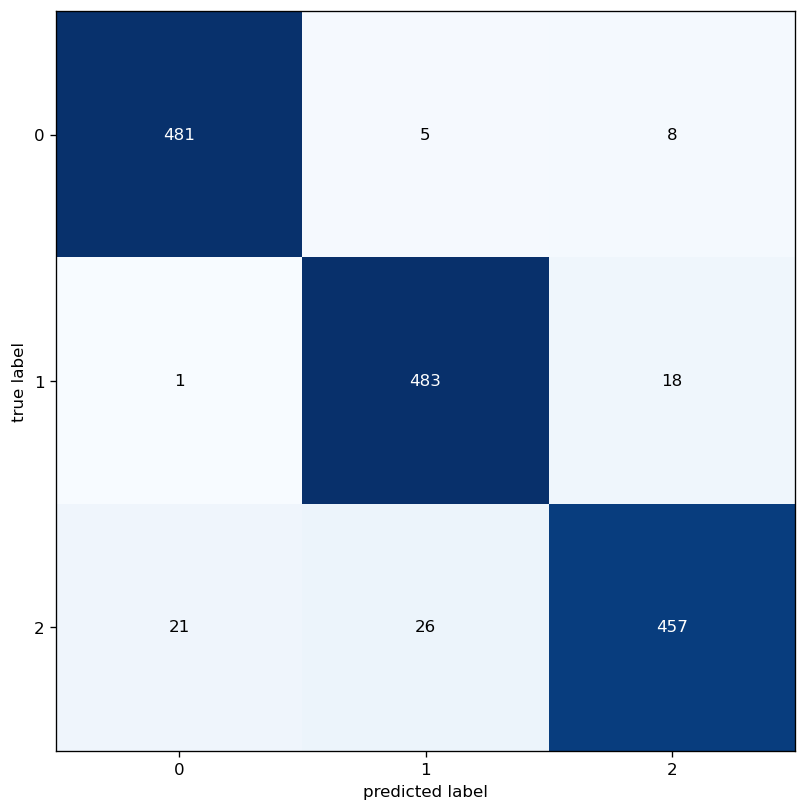

In [26]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(f"Modelo '{nome_estimador}', transformer '{nome_transformer}':")
plot_confusion_matrix(conf_mat=cm)
plt.show()

Aparentemente o modelo tem uma leve dificuldade em prever *tweets* de tom neutro. No entanto, mesmo nesse caso, **o *recall* para esta classe é superior a 90%**, corroborando o desempenho excelente.

Outros modelos que performaram muito bem foram **o estimador de *Random Forest* com *transformer* *Word2Vec***....

In [27]:
nome_pipeline = 'random_forest.word2vec'
nome_estimador, nome_transformer = nome_pipeline.split('.')
est = pipelines[nome_pipeline]

y_pred = est.predict(X_test)

print(f"Modelo '{nome_estimador}', transformer '{nome_transformer}':")
print(classification_report(
    y_true = y_test,
    y_pred = y_pred
))

Modelo 'random_forest', transformer 'word2vec':
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       494
           1       0.78      0.82      0.80       502
           2       0.86      0.84      0.85       504

    accuracy                           0.83      1500
   macro avg       0.83      0.83      0.83      1500
weighted avg       0.83      0.83      0.83      1500



Modelo 'random_forest', transformer 'word2vec':


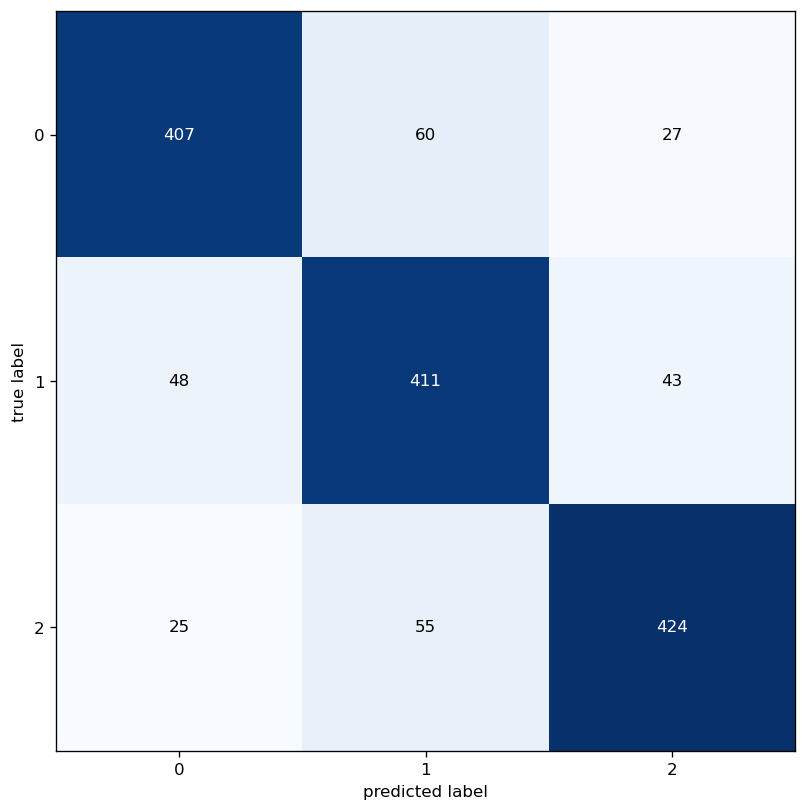

In [28]:
cm = confusion_matrix(y_test, y_pred)

print(f"Modelo '{nome_estimador}', transformer '{nome_transformer}':")
plot_confusion_matrix(conf_mat=cm)
plt.show()

... e o estimador ***XGBoost*, também com *transformer* *Word2Vec***:

In [29]:
nome_pipeline = 'xgboost.word2vec'
nome_estimador, nome_transformer = nome_pipeline.split('.')
est = pipelines[nome_pipeline]

y_pred = est.predict(X_test)

print(f"Modelo '{nome_estimador}', transformer '{nome_transformer}':")
print(classification_report(
    y_true = y_test,
    y_pred = y_pred
))

Modelo 'xgboost', transformer 'word2vec':
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       494
           1       0.78      0.82      0.80       502
           2       0.86      0.84      0.85       504

    accuracy                           0.82      1500
   macro avg       0.82      0.82      0.82      1500
weighted avg       0.82      0.82      0.82      1500



Modelo 'xgboost', transformer 'word2vec':


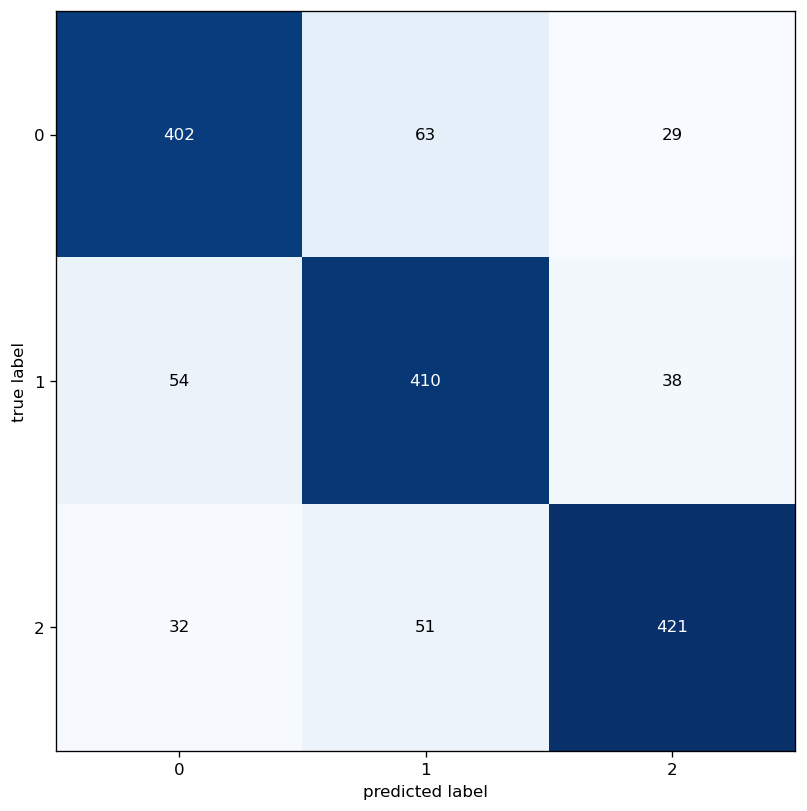

In [30]:
cm = confusion_matrix(y_test, y_pred)

print(f"Modelo '{nome_estimador}', transformer '{nome_transformer}':")
plot_confusion_matrix(conf_mat=cm)
plt.show()

Ainda que os estimadores *XGBoost* e *Random Forest* tenham performado muito bem, a performance da Regressão Logística foi incomparável em todas as métricas.

Vamos portanto prroseguir com a otimização desse modelo.

## Otimização do modelo de **Regressão Logística** com *transformer* ***Word2vec***.

Vamos otimizar agora o modelo fitado. Para tal, precisamos alterar seus hiperparâmetros e checar se o ajuste é melhor.

Para tal, primeiramente vamos definir quais hiperparâmetros vamos testar e com quais valores.

In [31]:
# definimos parâmetros de vários estimadores e transformers caso precisemos

otimizacoes = dict(
    tfidf = dict(
        use_idf = [True, False],
    ),
    word2vec = dict(
        vector_size = [10, 50, 100, 200],
        vector_combination = [ 'sum', 'mean' ],
    ),
    doc2vec = dict(
        vector_size = [10, 50, 100, 200],
    ),
    logistic = {
        'penalty': ['elasticnet', 'l1', 'l2'],
        'fit_intercept': [True, False],
        'solver': [ 'lbfgs', 'saga' ],
    },
    xgboost = {
        'criterion': ['friedman_mse', 'mae' ],
        'max_features': [ 'log2', 'sqrt' ],
        'learning_rate': [ 0.01, 0.05, 0.1, 0.5, 1, ],
        'max_depth': [ 3, 4, 5, 10 ],
        'n_estimators': [ 5 ,10, 15, 20, 100, 150 ],
    },
    random_forest = {
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [4,5,6,7,8],
        'criterion' :['gini', 'entropy']
    },
)

Vamos agora configurar a otimização:

In [32]:
from pprint import pprint

# para cada nome de modelo a ser otimizado, haverá um dicionário com a configuração da otimização

nomes_modelos = [ 'logistic.word2vec', 'random_forest.word2vec', 'xgboost.word2vec']

params = {}

for nome in nomes_modelos:
    params[nome] = {}
    for nome_pipe in nome.split('.'):
        for nome_param, valores_param in otimizacoes.get(nome_pipe, {}).items():
            params[nome][f'{nome_pipe}__{nome_param}'] = valores_param
    
    if not params[nome]:
        _ = params.pop(nome, None)

pprint(params)

{'logistic.word2vec': {'logistic__fit_intercept': [True, False],
                       'logistic__penalty': ['elasticnet', 'l1', 'l2'],
                       'logistic__solver': ['lbfgs', 'saga'],
                       'word2vec__vector_combination': ['sum', 'mean'],
                       'word2vec__vector_size': [10, 50, 100, 200]},
 'random_forest.word2vec': {'random_forest__criterion': ['gini', 'entropy'],
                            'random_forest__max_depth': [4, 5, 6, 7, 8],
                            'random_forest__max_features': ['auto',
                                                            'sqrt',
                                                            'log2'],
                            'random_forest__n_estimators': [200, 500],
                            'word2vec__vector_combination': ['sum', 'mean'],
                            'word2vec__vector_size': [10, 50, 100, 200]},
 'xgboost.word2vec': {'word2vec__vector_combination': ['sum', 'mean'],
            

Por fim, vamos executar a otimização.

Utilizaremos uma função de perda [***log loss***](https://en.wikipedia.org/wiki/Loss_functions_for_classification#Logistic_loss). 

A acurácia (ou nenhuma outra função que use como parâmetro de entrada as predições em si) não é recomendada como uma função de perda pois é uma [função de comparação imprópria (*Improper scoring rule*)](https://en.wikipedia.org/wiki/Scoring_rule); logo, não é adequada para comparar predições probabilísticas.

Exemplos de funções de comparação de predições probabilísticas são a própria *log loss*, a [*Brier loss*](https://en.wikipedia.org/wiki/Brier_score), a [*Square loss*](https://en.wikipedia.org/wiki/Loss_functions_for_classification#Square_loss), entre outras. 

In [33]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from datetime import datetime as dt

nome_score = 'neg_log_loss' # por que negativada? funções de perda tem seu ótimo no ponto de mínimo.
                            # a negativação transforma o ponto ótimo no ponto de máximo,
                            # o que é consistente com as outras métricas de desempenho
                            # disponíveis no scikit-learn
searchers = {}

cv = StratifiedKFold(
    n_splits = 3,
)

# deletar a variável t0 caso exista, para que a lógica de timing dos testes não se confunda
try:
    del t0
except NameError:
    pass

print('Iniciando busca...')
for nome_pipeline, hiperparams_otim in params.items():

    nome_estimador, nome_transformer = nome_pipeline.split('.')
    modelo = pipelines[nome_pipeline]
    
    try:
        tfim = dt.now()
        delta = tfim - t0
        print(f"... OK. (Duração da busca: {delta})\n")
    except NameError:   # variavel t0 não existe: primeira iteração do loop
        pass

    print(f"Procurando hiperparâmetros ótimos para o modelo '{nome_estimador}' com transformer '{nome_transformer}'... ")
    t0 = dt.now()
    random_search = RandomizedSearchCV(
        estimator = modelo, 
        param_distributions = hiperparams_otim, 
        scoring = nome_score,
        n_iter = 150,
        cv = cv, 
        verbose = 2,
        n_jobs = -1,
    )
    
    searchers[nome_pipeline] = random_search.fit(X_train, y_train)

tfim = dt.now()
delta = tfim - t0
print(f"... OK. (Duração da busca: {delta})")


Iniciando busca...
Procurando hiperparâmetros ótimos para o modelo 'logistic' com transformer 'word2vec'... 
Fitting 3 folds for each of 96 candidates, totalling 288 fits


E:\programacao\python\Anaconda3\envs\sentiment_analysis_twitter\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 96 is smaller than n_iter=150. Running 96 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
E:\programacao\python\Anaconda3\envs\sentiment_analysis_twitter\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
144 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "E:\programacao\python\Anaconda3\envs\sentiment_analysis_twitter\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
 

... OK. (Duração da busca: 0:00:23.235845)

Procurando hiperparâmetros ótimos para o modelo 'random_forest' com transformer 'word2vec'... 
Fitting 3 folds for each of 150 candidates, totalling 450 fits
... OK. (Duração da busca: 0:04:12.209363)

Procurando hiperparâmetros ótimos para o modelo 'xgboost' com transformer 'word2vec'... 
Fitting 3 folds for each of 150 candidates, totalling 450 fits
[17:14:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


... OK. (Duração da busca: 0:06:31.588536)


In [34]:
for nome_pipeline, searcher in searchers.items():
    nome_estimador, nome_transformer = nome_pipeline.split('.')
    print(f"Melhores parâmetros para o modelo '{nome_estimador}' com transformer '{nome_transformer}':")
    pprint(searcher.best_params_)
    print('')

Melhores parâmetros para o modelo 'logistic' com transformer 'word2vec':
{'logistic__fit_intercept': True,
 'logistic__penalty': 'l2',
 'logistic__solver': 'lbfgs',
 'word2vec__vector_combination': 'sum',
 'word2vec__vector_size': 50}

Melhores parâmetros para o modelo 'random_forest' com transformer 'word2vec':
{'random_forest__criterion': 'entropy',
 'random_forest__max_depth': 8,
 'random_forest__max_features': 'auto',
 'random_forest__n_estimators': 200,
 'word2vec__vector_combination': 'mean',
 'word2vec__vector_size': 200}

Melhores parâmetros para o modelo 'xgboost' com transformer 'word2vec':
{'word2vec__vector_combination': 'sum',
 'word2vec__vector_size': 200,
 'xgboost__criterion': 'friedman_mse',
 'xgboost__learning_rate': 0.5,
 'xgboost__max_depth': 4,
 'xgboost__max_features': 'sqrt',
 'xgboost__n_estimators': 150}



A melhora no desempenho de cada um dos modelos é:

In [35]:
cvresults = {}

for nome_modelo, searcher in searchers.items():
    rsdf = pd.DataFrame(searcher.cv_results_)
    rsdf = rsdf.set_index([ col for col in rsdf.columns if col.startswith('param_') ])
    cvresults[nome_modelo] = rsdf.sort_values(by = 'rank_test_score')

In [36]:
cvresults['xgboost.word2vec'].dropna()

mean_fit_time  \
param_xgboost__n_estimators param_xgboost__max_features param_xgboost__max_depth param_xgboost__learning_rate param_xgboost__criterion param_word2vec__vector_size param_word2vec__vector_combination                  
150                         sqrt                        4                        0.50                         friedman_mse             200                         sum                                     18.551377   
100                         log2                        4                        0.50                         friedman_mse             200                         sum                                     19.734877   
150                         log2                        5                        0.50                         friedman_mse             200                         sum                                     24.185971   
                                                        4                        1.00                         friedman_mse             200                         sum                                     17.210962   
                            sqrt                        4                        0.10                         mae                      200                         mean                                    23.114171   
...                                                                                                                                                                                                              ...   
5                           sqrt                        10                       0.01                         mae                      200                         mean                                     2.331430   
                                                                                                                                       100                         sum                                      3.425836   
15                          log2                        3                        0.01                         mae                      10                          sum                                      0.985696   
5                           sqrt                        5                        0.01                         friedman_mse             50                          sum                                      1.450453   
                                                        4                        0.01                         friedman_mse             200                         sum                                      1.158235   

                                                                                                                                                                                                       std_fit_time  \
param_xgboost__n_estimators param_xgboost__max_features param_xgboost__max_depth param_xgboost__learning_rate param_xgboost__criterion param_word2vec__vector_size param_word2vec__vector_combination                 
150                         sqrt                        4                        0.50                         friedman_mse             200                         sum                                     0.314286   
100                         log2                        4                        0.50                         friedman_mse             200                         sum                                     0.053083   
150                         log2                        5                        0.50                         friedman_mse             200                         sum                                     0.264553   
                                                        4                        1.00                         friedman_mse             200                         sum                                     0.156897   
                            sqrt                        4                        0.10               

In [37]:
from sklearn.metrics import SCORERS

fscore = SCORERS[nome_score]

print(f"Usando score = '{nome_score}'\n")

best_scores = { nome_modelo: searcher.best_score_ for nome_modelo, seacher in searchers.items() }

for nome_modelo in nomes_modelos:
    nome_estimador, nome_transformer = nome_modelo.split('.')
    modelo = pipelines[nome_pipeline]

    print(f"Resultados para modelo '{nome_estimador}' com transformer '{nome_transformer}':")
    score_original = fscore(
        estimator = pipelines[nome_modelo],
        X = X_test,
        y_true = y_test,
    )
    score_otimizado = cvresults[nome_modelo].iloc[0]['mean_test_score']

    if nome_score.startswith('neg'):
        melhoria = score_original / score_otimizado - 1
    else:
        melhoria = score_otimizado / score_original - 1

    frase_score_orig = f"Score '{nome_score}' original"
    frase_score_opt = f"Score '{nome_score}' otimizado"
    frase_melhoria = 'Melhoria'

    ncaract = len(frase_score_opt) + 4

    print(f"{frase_score_orig:>{ncaract}s}: {score_original:}")
    print(f"{frase_score_opt:>{ncaract}s}: {score_otimizado:}")
    print(f"{frase_melhoria:>{ncaract}s}: {melhoria:.3%}")
    print('')


Usando score = 'neg_log_loss'

Resultados para modelo 'logistic' com transformer 'word2vec':
     Score 'neg_log_loss' original: -0.37710553682403164
    Score 'neg_log_loss' otimizado: -0.45545523997773146
                          Melhoria: -17.203%

Resultados para modelo 'random_forest' com transformer 'word2vec':
     Score 'neg_log_loss' original: -0.5801350818124781
    Score 'neg_log_loss' otimizado: -0.44714173887737935
                          Melhoria: 29.743%

Resultados para modelo 'xgboost' com transformer 'word2vec':
     Score 'neg_log_loss' original: -0.4200579808129405
    Score 'neg_log_loss' otimizado: -0.20343321787893776
                          Melhoria: 106.484%



Surpreendentemente, **o modelo *XGBoost* com o *transformer* *Word2Vec* teve uma melhora significativa na *performance*, ultrapassando o modelo de regressão logística**. Vamos então utilizá-lo, com os parâmetros otimizados, para predizer o sentimento de novos *tweets*:

In [38]:
modelo_final = 'xgboost.word2vec'
nome_estimador, nome_transformer = modelo_final.split('.')

print(f"Parâmetros otimizados do modelo '{nome_estimador}' com transformer '{nome_transformer}':\n")

params_finais = cvresults[modelo_final].iloc[0]['params']

pprint(params_finais)

Parâmetros otimizados do modelo 'xgboost' com transformer 'word2vec':

{'word2vec__vector_combination': 'sum',
 'word2vec__vector_size': 200,
 'xgboost__criterion': 'friedman_mse',
 'xgboost__learning_rate': 0.5,
 'xgboost__max_depth': 4,
 'xgboost__max_features': 'sqrt',
 'xgboost__n_estimators': 150}
